# 0) Initialization

In [7]:
import util.Landau_Potential_Diffusion as Landau
import util.curvature as curve

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import datetime
from skimage import measure
from scipy import ndimage
import scipy.integrate as sin
from scipy.optimize import curve_fit

import pickle
import sys

In [8]:
path = '/nfs/twcroninlab002/tbeucler/ERA5/ERA5_LHF_SHF/'

In [9]:
MSE = xr.open_mfdataset(path+'????/??MSE.nc',combine='by_coords')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [10]:
MSE

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 166560)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2000-01-01 ... 2018-12-31T23:00:00
Data variables:
    p61.162    (time, latitude, longitude) float32 dask.array<shape=(166560, 721, 1440), chunksize=(744, 721, 1440)>
    p62.162    (time, latitude, longitude) float32 dask.array<shape=(166560, 721, 1440), chunksize=(744, 721, 1440)>
Attributes:
    Conventions:  CF-1.6
    history:      2018-10-25 15:55:44 GMT by grib_to_netcdf-2.7.0: /opt/ecmwf...

# 1) Save IQR,MED,MMI of column water vapor in time

In [11]:
dt = 3600
tcoor = dt*np.arange(0,MSE.time.shape[0])

In [12]:
latmin = -30
latmax = 30
lonmin = 300
lonmax = 360

MSEAtl = MSE['p62.162'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})
lonAtl = MSE.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = MSE.latitude.sel({'latitude':slice(latmax,latmin)})

In [13]:
YEAR = np.linspace(2000,2018,19).astype(int)
print(YEAR)

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018]


In [14]:
year = 1993
date1 = str(year)+'-01-01T00:00:00'
date2 = str(year)+'-12-31T23:00:00'
print(date1,date2)

1993-01-01T00:00:00 1993-12-31T23:00:00


Interquartile range

In [19]:
IQ = {}
for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year,'                ',end='\r')
    date1 = str(year)+'-01-01T00:00:00'
    date2 = str(year)+'-12-31T23:00:00'
    IQ[str(year)] = np.zeros((MSEAtl.time.sel({'time':slice(date1,date2)}).shape[0],))
    IQ[str(year)][:] = np.percentile(MSEAtl.sel({'time':slice(date1,date2)}),75,axis=(1,2))-\
    np.percentile(MSEAtl.sel({'time':slice(date1,date2)}),25,axis=(1,2))

Median

In [119]:
MED = {}
for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year,'                ',end='\r')
    date1 = str(year)+'-01-01T00:00:00'
    date2 = str(year)+'-12-31T23:00:00'
    MED[str(year)] = np.zeros((MSEAtl.time.sel({'time':slice(date1,date2)}).shape[0],))
    MED[str(year)][:] = np.percentile(MSEAtl.sel({'time':slice(date1,date2)}),50,axis=(1,2))

Moist Margin Index

In [ ]:
dx = 110/4 #km
L_CONTOUR = {}
it_tot = 0
for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year)
    date1 = str(year)+'-01-01T00:00:00'
    date2 = str(year)+'-12-31T23:00:00'
    Nt = MSEAtl.time.sel({'time':slice(date1,date2)}).shape[0]
    L_CONTOUR[str(year)] = np.zeros((Nt,))
    for it in range(Nt):
        print('it=',it,' & it_tot=',it_tot,'               ',end='\r')
        Contour = curve.get_contours(MSEAtl[it_tot,:,:]>MED_data['Median_MSE'][str(year)][it])
        L = 0
        for j,contour in enumerate(Contour):
            plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='k')
            L += np.sum(contour*dx)
        L_CONTOUR[str(year)][it] = L
        it_tot+=1

i= 0  & year= 2000


Save interquartile range and median time series to not have to re-calculate it

In [121]:
# hf = open('PKL_DATA/8_13_IQ.pkl','wb')
# hf = open('PKL_DATA/10_1_MED.pkl','wb')
# # IQ_data = { "Interquartile_range_MSE" : IQ, "time" : MSEAtl.time }
# # pickle.dump(IQ_data,hf)
# MED_data = { "Median_MSE" : MED, "time" : MSEAtl.time }
# pickle.dump(MED_data,hf) 
# hf.close()

# 2) Analyze most aggregated case (as measured by IQ range) among all years

## 2.1) Load data and select cases

In [20]:
hf = open('PKL_DATA/8_13_IQ.pkl','rb')
IQ_data = pickle.load(hf)

In [21]:
hf = open('PKL_DATA/10_1_MED.pkl','rb')
MED_data = pickle.load(hf)

In [26]:
CON_data = {}
for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year,' ',end='\r')
    hf = open('PKL_DATA/10_2_CONTOURL'+str(year)+'.pkl','rb')
    tmp = pickle.load(hf)
    CON_data[year] = tmp['Tot_Contour_km'][str(year)]

In [28]:
YEAR = np.linspace(2000,2018,19).astype(int)
# Max,min of interquartile range
max_year = np.zeros((YEAR.size,))
min_year = np.copy(max_year)
# Max,min of contour length
maxC_year = np.copy(max_year)
minC_year = np.copy(max_year)
for i,year in enumerate(YEAR):
    max_year[i] = IQ_data['Interquartile_range_MSE'][str(year)].max()
    min_year[i] = IQ_data['Interquartile_range_MSE'][str(year)].min()
    maxC_year[i] = CON_data[year].max()
    minC_year[i] = CON_data[year].min()

In [41]:
print('Max of IQ range')
for data in max_year:
    sys.stdout.write('  ')
    sys.stdout.write('{:03.0f}'.format(data/2.5e6))
print('\nMin of IQ range')
for data in min_year:
    sys.stdout.write('  ')
    sys.stdout.write('{:03.0f}'.format(data/2.5e6))
print('\nMax of contour L')
for data in maxC_year:
    sys.stdout.write('  ')
    sys.stdout.write('{:04.1f}'.format(data/1e6))
print('\nMin of contour L')
for data in minC_year:
    sys.stdout.write('  ')
    sys.stdout.write('{:04.1f}'.format(data/1e6))

Max of IQ range
  036  036  037  037  036  037  036  036  037  035  040  037  036  036  036  034  036  037  034
Min of IQ range
  017  016  016  018  017  018  016  017  019  017  017  017  017  016  018  018  017  019  018
Max of contour L
  17.8  17.2  18.2  17.7  18.7  17.8  18.8  17.4  17.3  17.5  18.5  19.2  17.8  19.5  16.6  18.7  18.9  16.8  18.7
Min of contour L
  06.3  05.8  05.8  05.2  04.7  05.7  05.1  05.1  05.7  05.9  04.8  05.3  05.7  06.0  05.4  05.3  05.5  05.3  00.0

## 2.2) Case 1 selected on IQ range, Slow aggregation fast disaggregation

In [42]:
imax = np.argmax(IQ_data['Interquartile_range_MSE']['2010'])
print('imax=',imax,' & IQ[imax]=',IQ_data['Interquartile_range_MSE']['2010'][imax]/2.5e6)

imax= 2433  & IQ[imax]= 39.9507968


Text(0, 0.5, 'IQ [kg/m2]')

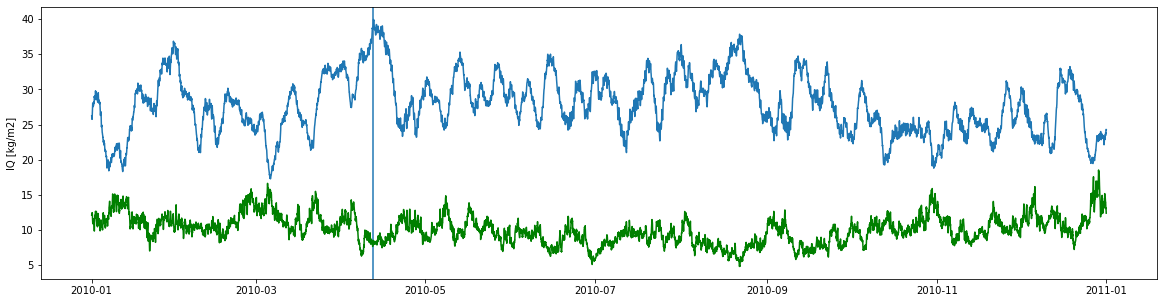

In [51]:
year = 2010
date1 = str(year)+'-01-01T00:00:00'
date2 = str(year)+'-12-31T23:00:00'
t2000 = MSEAtl.time.sel({'time':slice(date1,date2)})

plt.figure(figsize=(20,5))
plt.plot(t2000,IQ_data['Interquartile_range_MSE']['2010']/2.5e6)
plt.axvline(t2000[2433].values)
plt.plot(t2000,CON_data[2010]/1e6,color='g')
plt.ylabel('IQ [kg/m2]')

In [53]:
imin_left = np.argmin(IQ_data['Interquartile_range_MSE']['2010'][imax-1000:imax])+imax-1000

In [54]:
imin_right = np.argmin(IQ_data['Interquartile_range_MSE']['2010'][imax:imax+1000])+imax

Text(0, 0.5, 'IQ [kg/m2]')

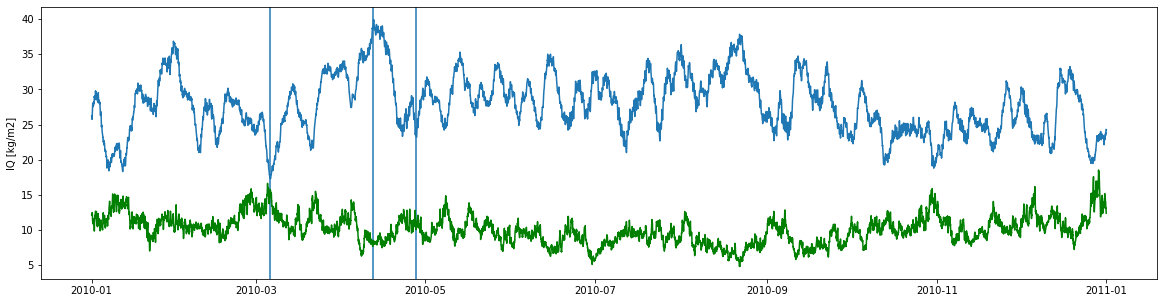

In [55]:
plt.figure(figsize=(20,5))
plt.plot(t2000,IQ_data['Interquartile_range_MSE']['2010']/2.5e6)
plt.axvline(t2000[imax].values)
plt.axvline(t2000[imin_left].values)
plt.axvline(t2000[imin_right].values)
plt.plot(t2000,CON_data[2010]/1e6,color='g')
plt.ylabel('IQ [kg/m2]')

In [56]:
LSM = xr.open_mfdataset(path+'ERA_LANDSEAMASK.nc')

/home/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [57]:
def index_date(time_array,date_string):
    return [i for i, x in enumerate(time_array.sel({'time':date_string})==time_array) if x]

In [58]:
def date_index(time_array,time_index):
    return time_array[time_index].values

In [62]:
iJan1_2010 = index_date(MSEAtl.time,date1)

i= 0  & date= ['2010-03-06T07:00:00.000000000']
Defining moist margin
Measuring contour length
i= 1  & date= ['2010-04-12T09:00:00.000000000']
Defining moist margin
Measuring contour length
i= 2  & date= ['2010-04-27T20:00:00.000000000']
Defining moist margin
Measuring contour length


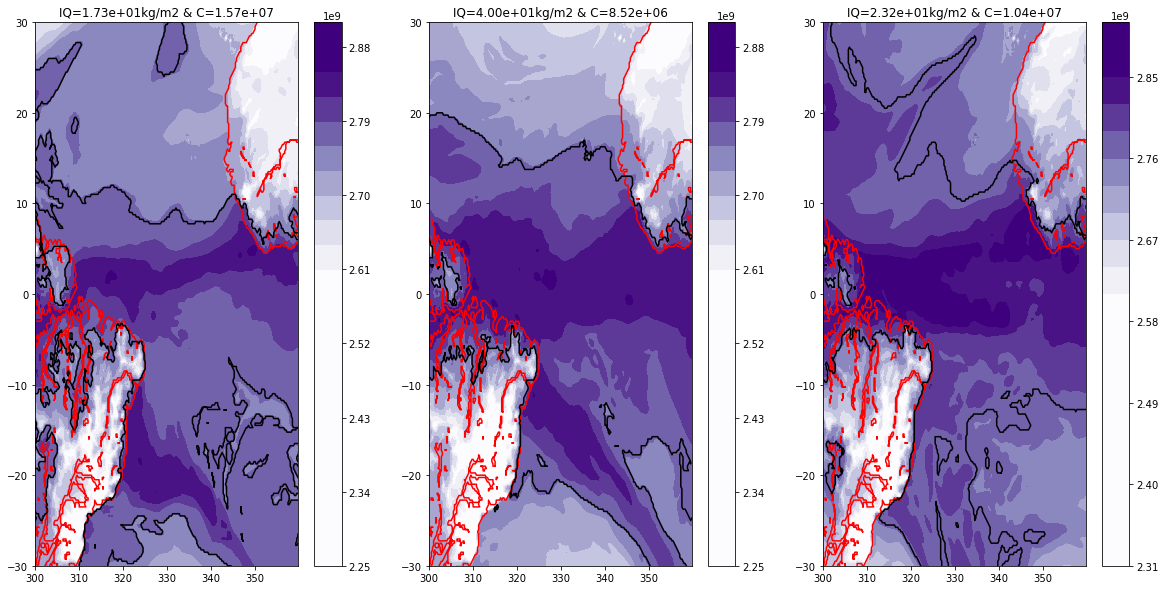

In [64]:
dx = 110/4
vmin = 2.6e9
vmax = 2.85e9

Tstr2010 = [imin_left,imax,imin_right]

plt.figure(figsize=(20,10))

for i,it2010 in enumerate(Tstr2010):
    it = it2010+iJan1_2010
    date = MSEAtl.time[it].values
    print('i=',i,' & date=',date)
    plt.subplot(1,3,i+1)
    plt.contourf(lonAtl,latAtl,MSEAtl.sel({'time':date})[0,:,:],cmap='Purples',levels=20,vmin=vmin,vmax=vmax)
    
    Land = curve.get_contours(LSM.lsm.sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})[0,:,:]>0.99)
    for j,contour in enumerate(Land):
        plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='r')
    
    print('Defining moist margin')
    Contour = curve.get_contours(MSEAtl.sel({'time':date})[0,:,:]>MED_data['Median_MSE']['2010'][it2010])
    print('Measuring contour length')
    L = 0
    for j,contour in enumerate(Contour):
        plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='k')
        L += np.sum(contour*dx)
    
    plt.colorbar()
    plt.title('IQ='+"%0.2e"%(IQ_data['Interquartile_range_MSE']['2010'][it2010]/2.5e6)+'kg/m2 & C='+"%0.2e"%L)

## 2.3) Case 2 selected on C length, fast aggregation slow disaggregation

In [66]:
iminC = np.argmin(CON_data[2004])
print('imin=',iminC,' & CON[imin]=',CON_data[2004][iminC]/1e6)

imin= 5976  & CON[imin]= 4.7437775


Text(0, 0.5, 'IQ [kg/m2]')

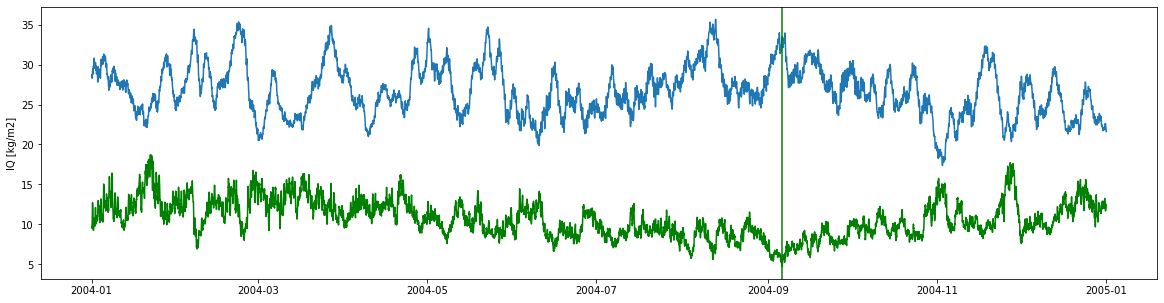

In [68]:
year = 2004
date1 = str(year)+'-01-01T00:00:00'
date2 = str(year)+'-12-31T23:00:00'
t2004 = MSEAtl.time.sel({'time':slice(date1,date2)})

plt.figure(figsize=(20,5))
plt.plot(t2004,IQ_data['Interquartile_range_MSE'][str(year)]/2.5e6)
plt.axvline(t2004[iminC].values,color='g')
plt.plot(t2004,CON_data[year]/1e6,color='g')
plt.ylabel('IQ [kg/m2]')

In [69]:
imax_left = np.argmax(CON_data[year][iminC-500:iminC])+iminC-500

In [70]:
imax_right = np.argmax(CON_data[year][iminC:iminC+1000])+iminC

Text(0, 0.5, 'IQ [kg/m2]')

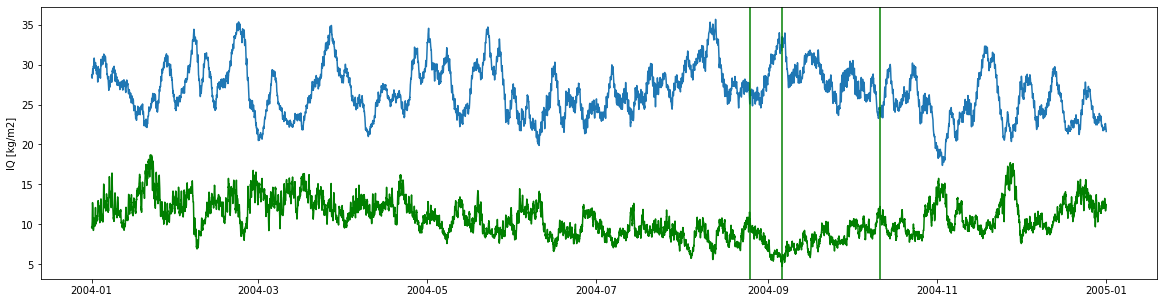

In [71]:
plt.figure(figsize=(20,5))
plt.plot(t2004,IQ_data['Interquartile_range_MSE'][str(year)]/2.5e6)
plt.axvline(t2004[iminC].values,color='g')
plt.axvline(t2004[imax_left].values,color='g')
plt.axvline(t2004[imax_right].values,color='g')
plt.plot(t2004,CON_data[year]/1e6,color='g')
plt.ylabel('IQ [kg/m2]')

In [72]:
iJan1_2004 = index_date(MSEAtl.time,date1)

In [ ]:
dx = 110/4
vmin = 2.6e9
vmax = 2.85e9

Tstr2004 = [imin_left,imax,imin_right]

plt.figure(figsize=(20,10))

for i,it2004 in enumerate(Tstr2004):
    it = it2004+iJan1_2004
    date = MSEAtl.time[it].values
    print('i=',i,' & date=',date)
    plt.subplot(1,3,i+1)
    plt.contourf(lonAtl,latAtl,MSEAtl.sel({'time':date})[0,:,:],cmap='Purples',levels=20,vmin=vmin,vmax=vmax)
    
    Land = curve.get_contours(LSM.lsm.sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})[0,:,:]>0.99)
    for j,contour in enumerate(Land):
        plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='r')
    
    print('Defining moist margin')
    Contour = curve.get_contours(MSEAtl.sel({'time':date})[0,:,:]>MED_data['Median_MSE'][str(year)][it2004])
    print('Measuring contour length')
    L = 0
    for j,contour in enumerate(Contour):
        plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='k')
        L += np.sum(contour*dx)
    
    plt.colorbar()
    plt.title('IQ='+"%0.2e"%(IQ_data['Interquartile_range_MSE'][str(year)][it2004]/2.5e6)+'kg/m2 & C='+"%0.2e"%L+\
              '|'+"%0.2e"%(CON_data[year][it2004]/1e6))

i= 0  & date= ['2004-03-05T07:00:00.000000000']
Defining moist margin
Measuring contour length
i= 1  & date= ['2004-04-11T09:00:00.000000000']
Defining moist margin
Measuring contour length
i= 2  & date= ['2004-04-26T20:00:00.000000000']


# 2.4) Save all cases for future use

In [ ]:
hf = open('PKL_DATA/10_7_CASES.pkl','wb')
CASE_data = {"Case1":(imax,imin_left,imin_right),"Case2":(iminC,imax_left,imax_right)}
pickle.dump(CASE_data,hf)